Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [25]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
import matplotlib.pyplot as plt

from icecream import ic
from tqdm import tqdm

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [26]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [27]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [28]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [29]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(258.4309517988287))

In [30]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.False_, np.float64(123.4085136909273))

## Initial Heuristics considerations

If an element is present in one set only, that set must be included in the solution

In [31]:
# Initializes a solution that does not include any set.
initial_solution = np.full(NUM_SETS, False)

# For each element in the universe, if there is only one set that includes
# that element, adds that set to the initial solution.
for s in range(UNIVERSE_SIZE):
    if np.count_nonzero(SETS[:, s]) > 1:
        continue
    
    set_idx = np.argwhere(SETS[:, s] == True)
    solution[set_idx] = True

# Saves the initial solution (containing only the mandatory sets)
mandatory_sets = initial_solution

## Random Mutation Hill Climber

We run a RMHC algorithm, preserving the mandatory sets.

To evaluate the fitness, we check the number of elements included in the solution and the cost of the solution (in order).

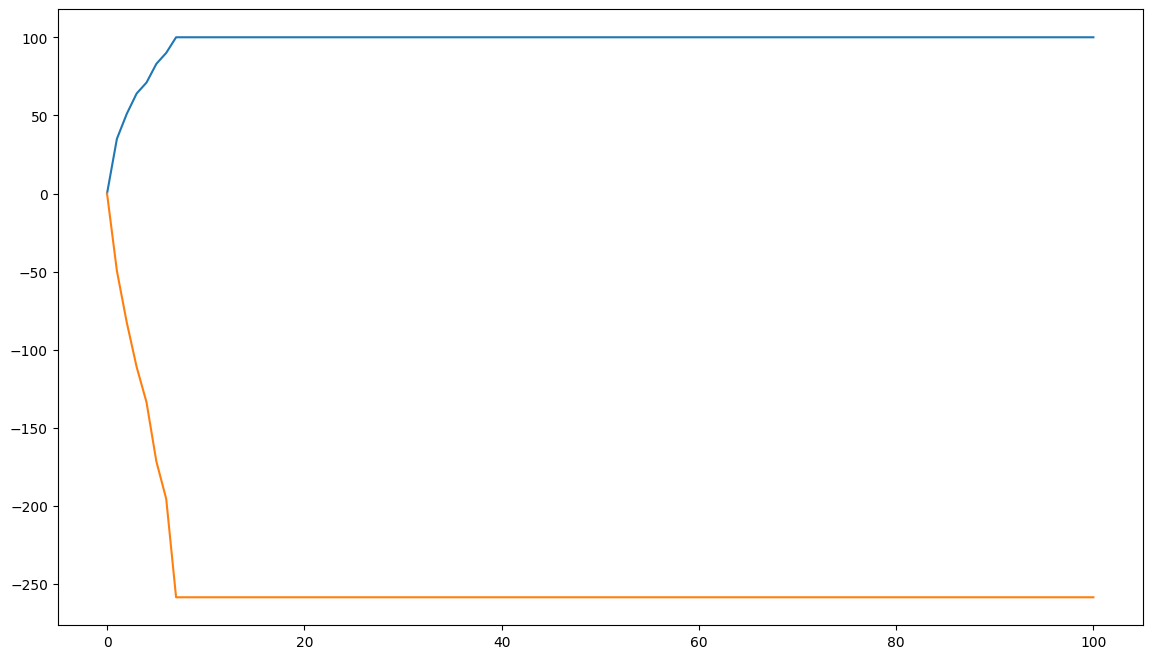

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 (100, np.float64(-258.4309517988287)),
 7)

In [32]:
# The number of iterations the algorithm will perform.
NUM_STEPS = 100

# The function used to tweak a solution.
def tweak(intermediate_solution):
    # Check for sets that can be changed.
    # If no set can be changed (i.e. all sets are mandatory), return the unchanged solution.
    non_mandatory_indexes = np.argwhere(mandatory_sets == False)
    if non_mandatory_indexes.size == 0:
        return intermediate_solution

    indexes_to_change = non_mandatory_indexes

    if not np.all(intermediate_solution):
        # Retrieves the indexes of the sets that are yet to be added to the solution.
        indexes_to_change = np.argwhere(intermediate_solution == False)

    # Adds a number of sets to the solution, with a probability of adding a new
    # set decreasing with the number of sets already added in the same step.
    index = None
    while index is None or rng.random() < 0.4:
        index = rng.choice(indexes_to_change)
        intermediate_solution[index] = True

    return intermediate_solution

# The function used to evaluate the fitness of a solution.
def fitness(intermediate_solution):
    c = cost(intermediate_solution)

    return np.count_nonzero(np.count_nonzero(SETS[intermediate_solution], axis=0)), -c

# Initializes the solution to be improved
solution = initial_solution
# Initializes a list containing the history of fitness of
# the intermediate solutions
history = [fitness(solution)]

# Applies the Hill Climber algorithm
for i in (range(NUM_STEPS)):
    new_solution = tweak(solution.copy())
    history.append(fitness(new_solution))

    if fitness(new_solution) > fitness(solution):
        solution = new_solution

# Plots the history of fitness of the intermediate solutions.
plt.figure(figsize=(14,8))
plt.plot(range(len(history)), list(accumulate(history, max)))
plt.show()

solution, (fitness(solution)), history.index(fitness(solution))